# Proceso  de EDA para estudiar los datos, y preparacion para hacer un modelo de recomendacion

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip

## Steam Games

In [ ]:
steam_games = pd.read_csv('./datasets/steam_games.csv')

In [ ]:
steam_games.info()

In [ ]:
fig,ax = plt.subplots(1,3)
sns.boxplot(data=steam_games,y='price',ax = ax[0])
sns.boxplot(data=steam_games,y='price',ax = ax[1])
sns.boxplot(data=steam_games,y='price',ax = ax[2])
ax[0].set_ylim(0,100)
ax[1].set_ylim(0,400)
ax[2].set_ylim(0,800)
plt.show()

### En el grafico se puede ver que la columna price tiene muchos valores atipicos que superan los 20 y llegan a los 1000, sin embargo en una app de juegos es posible tener tal distribucion, es decir muchos juegos de precio bajo y varios de precio alto por esto no se hara un tratado especial

In [ ]:
sns.histplot(data=steam_games,x='Year',hue='Free to Play',bins=10,palette='rainbow',multiple='dodge')

plt.ylim(0,20000)
plt.show()

### 2015 es el año con mas juegos y mas juegos Free To Play

## Users Reviews

In [ ]:
user_review = pd.read_csv('./datasets/user_reviews.csv')

In [ ]:
user_review.sample(5)

In [ ]:
sns.histplot(data=user_review,x='sentiment_analysis',bins=10,palette='rainbow',hue='recommend')

plt.show()

### Como se ve del total de sentimiento malos, un alto porcentaje son recomendaciones falsas, y de los buenos el total de recomendaciones true son altas, Para ambas hay un porcentaje existente de recomendaciones que parecen opuesta al sentimiento

## Users Items

In [5]:
with gzip.open('datasets/user_items_proc.csv.gz', 'rb') as f:
    user_items_proc = pd.read_csv(f, encoding='utf-8')

In [6]:
user_items_proc.sample(5)

,user_id,items_count,steam_id,user_url,item_id,item_name,playtime_forever,playtime_2weeks
3834437,defected00,74,76561197962151545,http://steamcommunity.com/id/defected00,407530.0,ARK: Survival Of The Fittest,0.0,0.0
915013,Napalm_Industry,455,76561198035066628,http://steamcommunity.com/id/Napalm_Industry,207610.0,The Walking Dead,685.0,0.0
31845,mrpfresh,791,76561197974266367,http://steamcommunity.com/id/mrpfresh,212910.0,Call of Duty: Black Ops II - Zombies,1.0,0.0
2006524,myeyesarepuzzlepieces,196,76561197994759419,http://steamcommunity.com/id/myeyesarepuzzlepi...,200510.0,XCOM: Enemy Unknown,4853.0,0.0
2320117,76561198067764491,94,76561198067764491,http://steamcommunity.com/profiles/76561198067...,4760.0,Rome: Total War,283.0,0.0


In [7]:
user_items_proc['item_id'].nunique()

10978

In [4]:
user_items_proc.describe()

,items_count,steam_id,item_id,playtime_forever,playtime_2weeks
count,5.153209e+06,5.153209e+06,5.153209e+06,5.153209e+06,5.153209e+06
mean,3.147229e+02,7.656120e+16,1.784481e+05,9.914951e+02,9.104707e+00
std,6.933596e+02,3.916645e+07,1.318598e+05,5.418204e+03,1.403926e+02
min,1.000000e+00,7.656120e+16,1.000000e+01,0.000000e+00,0.000000e+00
25%,7.200000e+01,7.656120e+16,3.446000e+04,0.000000e+00,0.000000e+00
50%,1.380000e+02,7.656120e+16,2.144200e+05,3.400000e+01,0.000000e+00
75%,2.760000e+02,7.656120e+16,2.664300e+05,3.550000e+02,0.000000e+00
max,7.762000e+03,7.656120e+16,5.307200e+05,6.427730e+05,1.996700e+04


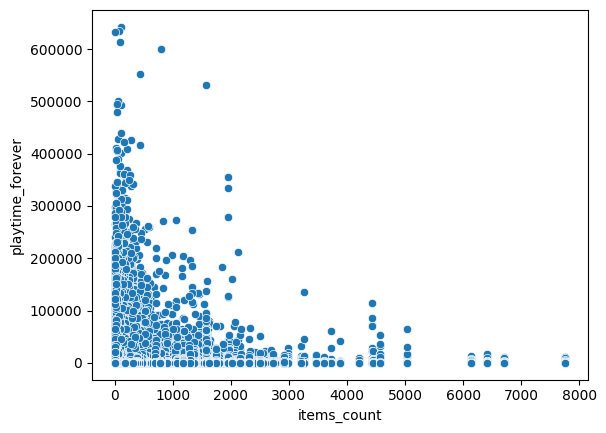

In [9]:
sns.scatterplot(data=user_items_proc,x='items_count',y='playtime_forever')
plt.show()